# Install dependencies

In [1]:
!pip uninstall sports -y
!pip install -q git+https://github.com/Gareth1995/sports.git

Found existing installation: sports 0.1.0
Uninstalling sports-0.1.0:
  Successfully uninstalled sports-0.1.0


In [2]:
import os
import numpy as np
from inference import get_model
import supervision as sv
from tqdm import tqdm
from typing import List
from sports.common.team import TeamClassifier # this is pulling the model that separates players into teams (the code we done but a remote model)
from sports.common.view import ViewTransformer
from sports.configs.soccer import SoccerPitchConfiguration
from sports.configs.soccer import StatsbombSoccerPitchConfiguration

from sports.annotators.soccer import (
    draw_pitch,
    draw_points_on_pitch,
    draw_pitch_voronoi_diagram
)

[09/01/24 23:17:53] WARNING  Your inference package version 0.16.3 is out of date! Please upgrade to ]8;id=354945;file://c:\Users\GEdwards\miniconda3\envs\roboflow_env\lib\site-packages\inference\core\__init__.py\__init__.py]8;;\:]8;id=636099;file://c:\Users\GEdwards\miniconda3\envs\roboflow_env\lib\site-packages\inference\core\__init__.py#35\35]8;;\
                             version 0.17.0 of inference for the latest features and bug fixes by                  
                             running `pip install --upgrade inference`.                                            

SupervisionWarnings: BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.


In [3]:
# Video in use
SOURCE_VIDEO_PATH = "data/arsenal_goal.mp4"

# Get Models

In [5]:
os.environ["ONNXRUNTIME_EXECUTION_PROVIDERS"] = "[CPUExecutionProvider]"
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"  # provides a safe threaded environment for models used in team classifier (I think)

# Player Detection
PLAYER_DETECTION_MODEL_ID = "football-players-detection-3zvbc/11"
PLAYER_DETECTION_MODEL = get_model(model_id=PLAYER_DETECTION_MODEL_ID, api_key='g0kReC3ubPe9dTtlz7uN')

# Field detection
FIELD_DETECTION_MODEL_ID = "football-field-detection-f07vi/14"
FIELD_DETECTION_MODEL = get_model(model_id=FIELD_DETECTION_MODEL_ID, api_key='g0kReC3ubPe9dTtlz7uN')

# Team classifier
PLAYER_ID = 2
STRIDE = 30 # use every 30th frame in the video

frame_generator = sv.get_video_frames_generator(
    source_path=SOURCE_VIDEO_PATH, stride=STRIDE)

crops = []
for frame in tqdm(frame_generator, desc='collecting crops'):
    result = PLAYER_DETECTION_MODEL.infer(frame, confidence=0.3)[0]
    detections = sv.Detections.from_inference(result)
    players_detections = detections[detections.class_id == PLAYER_ID]
    players_crops = [sv.crop_image(frame, xyxy) for xyxy in detections.xyxy]
    crops += players_crops

team_classifier = TeamClassifier(device="cpu")
team_classifier.fit(crops)

collecting crops: 23it [02:48,  7.34s/it]
Embedding extraction: 15it [08:30, 34.06s/it]
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md



In [6]:
# Utility functions 
def resolve_goalkeepers_team_id(
    players: sv.Detections,
    goalkeepers: sv.Detections
) -> np.ndarray:
    goalkeepers_xy = goalkeepers.get_anchors_coordinates(sv.Position.BOTTOM_CENTER)
    players_xy = players.get_anchors_coordinates(sv.Position.BOTTOM_CENTER)
    team_0_centroid = players_xy[players.class_id == 0].mean(axis=0)
    team_1_centroid = players_xy[players.class_id == 1].mean(axis=0)
    goalkeepers_team_id = []
    for goalkeeper_xy in goalkeepers_xy:
        dist_0 = np.linalg.norm(goalkeeper_xy - team_0_centroid)
        dist_1 = np.linalg.norm(goalkeeper_xy - team_1_centroid)
        goalkeepers_team_id.append(0 if dist_0 < dist_1 else 1)

    return np.array(goalkeepers_team_id)

In [7]:
# configure pitch
CONFIG = SoccerPitchConfiguration()
CONFIG_statsbomb = StatsbombSoccerPitchConfiguration()

annotated_frame = draw_pitch(CONFIG)
annotated_frame_statsbomb = draw_pitch(CONFIG_statsbomb)

Embedding extraction: 1it [00:08,  8.26s/it]


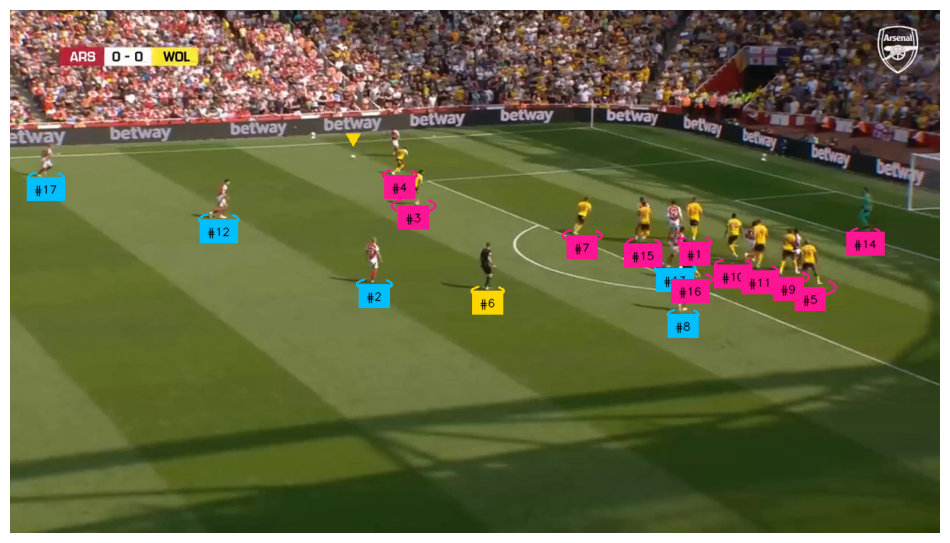

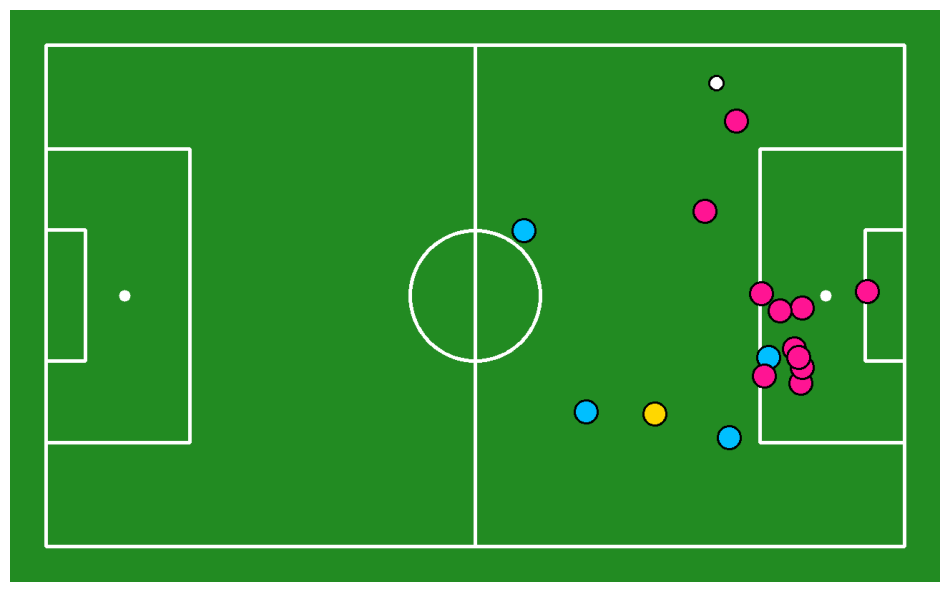

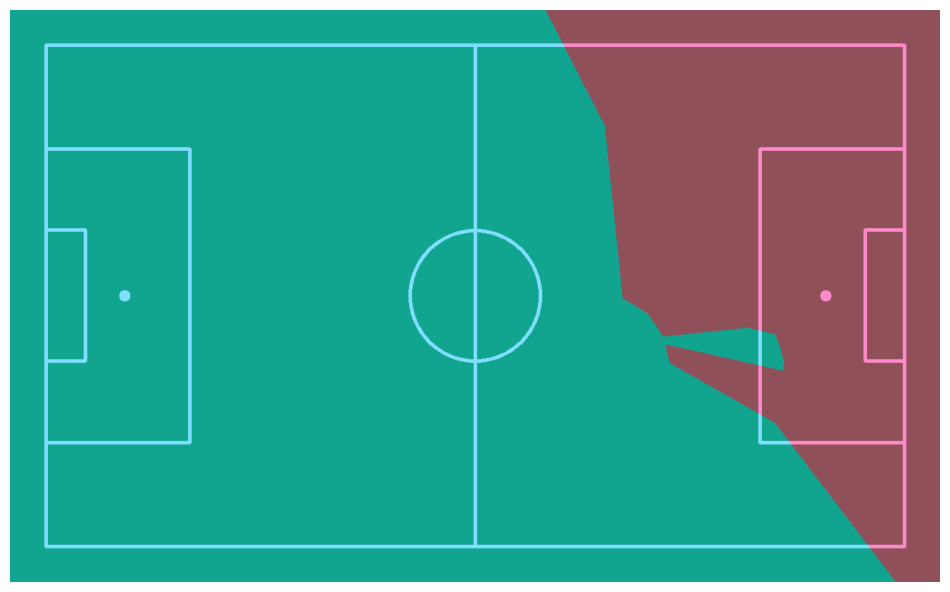

In [8]:
# everything put together

SOURCE_VIDEO_PATH = "data/arsenal_goal.mp4"
BALL_ID = 0
GOALKEEPER_ID = 1
PLAYER_ID = 2
REFEREE_ID = 3

ellipse_annotator = sv.EllipseAnnotator(
    color=sv.ColorPalette.from_hex(['#00BFFF', '#FF1493', '#FFD700']),
    thickness=2
)
label_annotator = sv.LabelAnnotator(
    color=sv.ColorPalette.from_hex(['#00BFFF', '#FF1493', '#FFD700']),
    text_color=sv.Color.from_hex('#000000'),
    text_position=sv.Position.BOTTOM_CENTER
)
triangle_annotator = sv.TriangleAnnotator(
    color=sv.Color.from_hex('#FFD700'),
    base=20, height=17
)

tracker = sv.ByteTrack()
tracker.reset()

frame_generator = sv.get_video_frames_generator(SOURCE_VIDEO_PATH)
frame = next(frame_generator)

# ball, goalkeeper, player, referee detection

result = PLAYER_DETECTION_MODEL.infer(frame, confidence=0.3)[0]
detections = sv.Detections.from_inference(result)

ball_detections = detections[detections.class_id == BALL_ID]
ball_detections.xyxy = sv.pad_boxes(xyxy=ball_detections.xyxy, px=10)

all_detections = detections[detections.class_id != BALL_ID]
all_detections = all_detections.with_nms(threshold=0.5, class_agnostic=True)
all_detections = tracker.update_with_detections(detections=all_detections)

goalkeepers_detections = all_detections[all_detections.class_id == GOALKEEPER_ID]
players_detections = all_detections[all_detections.class_id == PLAYER_ID]
referees_detections = all_detections[all_detections.class_id == REFEREE_ID]

# team assignment

players_crops = [sv.crop_image(frame, xyxy) for xyxy in players_detections.xyxy]
players_detections.class_id = team_classifier.predict(players_crops)

goalkeepers_detections.class_id = resolve_goalkeepers_team_id(
    players_detections, goalkeepers_detections)

referees_detections.class_id -= 1

all_detections = sv.Detections.merge([
    players_detections, goalkeepers_detections, referees_detections])

# frame visualization

labels = [
    f"#{tracker_id}"
    for tracker_id
    in all_detections.tracker_id
]

all_detections.class_id = all_detections.class_id.astype(int)

annotated_frame = frame.copy()
annotated_frame = ellipse_annotator.annotate(
    scene=annotated_frame,
    detections=all_detections)
annotated_frame = label_annotator.annotate(
    scene=annotated_frame,
    detections=all_detections,
    labels=labels)
annotated_frame = triangle_annotator.annotate(
    scene=annotated_frame,
    detections=ball_detections)

sv.plot_image(annotated_frame)


players_detections = sv.Detections.merge([
    players_detections, goalkeepers_detections
])

# detect pitch key points

result = FIELD_DETECTION_MODEL.infer(frame, confidence=0.3)[0]
key_points = sv.KeyPoints.from_inference(result)

# project ball, players and referies on pitch

filter = key_points.confidence[0] > 0.5
frame_reference_points = key_points.xy[0][filter]
pitch_reference_points = np.array(CONFIG_statsbomb.vertices)[filter]

# Here's where homography takes place (edit target to have statsbomb pitch measurements so that player xy and ball xy can be plotted using mplsoccer)
transformer = ViewTransformer(
    source=frame_reference_points,
    target=pitch_reference_points
)

frame_ball_xy = ball_detections.get_anchors_coordinates(sv.Position.BOTTOM_CENTER)
pitch_ball_xy = transformer.transform_points(points=frame_ball_xy)

players_xy = players_detections.get_anchors_coordinates(sv.Position.BOTTOM_CENTER)
pitch_players_xy = transformer.transform_points(points=players_xy)

referees_xy = referees_detections.get_anchors_coordinates(sv.Position.BOTTOM_CENTER)
pitch_referees_xy = transformer.transform_points(points=referees_xy)

annotated_frame = draw_pitch(CONFIG)
annotated_frame = draw_points_on_pitch(
    config=CONFIG,
    xy=pitch_ball_xy,
    face_color=sv.Color.WHITE,
    edge_color=sv.Color.BLACK,
    radius=10,
    pitch=annotated_frame)
annotated_frame = draw_points_on_pitch(
    config=CONFIG,
    xy=pitch_players_xy[players_detections.class_id == 0],
    face_color=sv.Color.from_hex('00BFFF'),
    edge_color=sv.Color.BLACK,
    radius=16,
    pitch=annotated_frame)
annotated_frame = draw_points_on_pitch(
    config=CONFIG,
    xy=pitch_players_xy[players_detections.class_id == 1],
    face_color=sv.Color.from_hex('FF1493'),
    edge_color=sv.Color.BLACK,
    radius=16,
    pitch=annotated_frame)
annotated_frame = draw_points_on_pitch(
    config=CONFIG,
    xy=pitch_referees_xy,
    face_color=sv.Color.from_hex('FFD700'),
    edge_color=sv.Color.BLACK,
    radius=16,
    pitch=annotated_frame)

sv.plot_image(annotated_frame)

annotated_frame = draw_pitch(CONFIG)
annotated_frame = draw_pitch_voronoi_diagram(
    config=CONFIG,
    team_1_xy=pitch_players_xy[players_detections.class_id == 0],
    team_2_xy=pitch_players_xy[players_detections.class_id == 1],
    team_1_color=sv.Color.from_hex('00BFFF'),
    team_2_color=sv.Color.from_hex('FF1493'),
    pitch=annotated_frame)

sv.plot_image(annotated_frame)

In [8]:
# Arsenal xT
arsenal_xt = [[1.22864434e-04, 1.53993958e-04, 1.88009372e-04, 3.11256835e-04,
        3.14493153e-04, 7.98694421e-04, 9.48561772e-04, 1.47960812e-03,
        1.60628443e-03, 3.55071489e-03, 5.30780197e-03, 8.24114013e-03,
        1.22571532e-02, 1.49203810e-02, 2.25618316e-02, 5.75568624e-02],
       [1.60208555e-04, 2.22973611e-04, 2.74215429e-04, 2.92259591e-04,
        7.92376787e-04, 5.89032912e-04, 9.49792166e-04, 1.48894132e-03,
        2.09604140e-03, 3.78825366e-03, 6.30058463e-03, 1.13583943e-02,
        1.67213543e-02, 2.35711133e-02, 2.99616828e-02, 3.12241228e-02],
       [1.10509824e-04, 1.55682167e-04, 3.08499556e-04, 3.41954377e-04,
        4.97272686e-04, 4.04656900e-04, 8.32925803e-04, 1.44823427e-03,
        2.52731103e-03, 4.04042652e-03, 7.28963655e-03, 1.31047798e-02,
        2.11892617e-02, 3.07976702e-02, 3.67096255e-02, 5.31224238e-02],
       [2.52434745e-04, 3.96743578e-04, 3.57174052e-04, 6.08781458e-04,
        4.58288124e-04, 5.95962156e-04, 9.50331253e-04, 1.35563815e-03,
        2.52218242e-03, 5.25416716e-03, 9.62231548e-03, 1.56199743e-02,
        2.82696425e-02, 4.26779887e-02, 5.89590471e-02, 7.61236308e-02],
       [2.95620043e-04, 5.00603399e-04, 4.08426424e-04, 4.46400176e-04,
        5.37268611e-04, 6.42299030e-04, 8.63768416e-04, 1.35749832e-03,
        3.21378556e-03, 5.88574352e-03, 9.43646007e-03, 1.66930583e-02,
        3.10734162e-02, 5.28689705e-02, 1.10300519e-01, 9.02142363e-02],
       [1.44091553e-03, 7.31299698e-04, 7.54245442e-04, 6.63217281e-04,
        3.68710288e-04, 7.02390338e-04, 9.08720535e-04, 1.81499938e-03,
        3.01482711e-03, 6.20076052e-03, 1.08706187e-02, 1.98406420e-02,
        3.16844192e-02, 6.79409521e-02, 1.30817892e-01, 2.74726608e-01],
       [1.23408788e-03, 6.36822841e-04, 8.19224103e-04, 7.21919063e-04,
        6.73222780e-04, 8.02806622e-04, 9.79071538e-04, 1.95362751e-03,
        2.19530282e-03, 5.48466854e-03, 8.56065635e-03, 1.89171754e-02,
        3.12404361e-02, 7.10194006e-02, 1.31567816e-01, 2.30320859e-01],
       [3.26844900e-04, 8.25291698e-04, 5.58255994e-04, 1.10468806e-03,
        7.11442392e-04, 7.53899906e-04, 9.96535335e-04, 2.04110852e-03,
        2.59495111e-03, 4.36704139e-03, 1.05871520e-02, 1.79770150e-02,
        3.03319004e-02, 5.03855274e-02, 9.96748049e-02, 1.27389668e-01],
       [3.92589020e-04, 4.20312309e-04, 4.09510097e-04, 4.26253648e-04,
        6.40998887e-04, 5.24711437e-04, 1.01467953e-03, 1.48275746e-03,
        2.30628583e-03, 4.70130255e-03, 8.47648117e-03, 1.53804902e-02,
        2.41244939e-02, 3.68959914e-02, 6.33526619e-02, 8.19106659e-02],
       [3.40778009e-04, 1.49283852e-04, 2.26511968e-04, 4.14703956e-04,
        8.57042782e-04, 6.77407740e-04, 8.64968227e-04, 1.42843851e-03,
        2.98153127e-03, 5.16514730e-03, 7.88621801e-03, 1.29212804e-02,
        2.36352348e-02, 3.08831973e-02, 4.46774459e-02, 5.75023103e-02],
       [8.93928057e-05, 1.45005698e-04, 2.48160691e-04, 5.23278032e-04,
        7.10408440e-04, 8.07560105e-04, 7.89115258e-04, 1.47788474e-03,
        2.62153790e-03, 3.57960854e-03, 6.77805806e-03, 1.07538288e-02,
        1.94249470e-02, 2.79214571e-02, 3.52900813e-02, 4.57487134e-02],
       [1.04338017e-04, 1.78418334e-04, 2.07630295e-04, 2.25150810e-04,
        3.19538706e-04, 4.51240677e-04, 1.17245442e-03, 1.13654930e-03,
        1.81155062e-03, 3.50306679e-03, 5.09185106e-03, 9.34532163e-03,
        1.41230002e-02, 1.94168900e-02, 2.61659834e-02, 8.44230949e-02]]

In [9]:
print(pitch_ball_xy)

# convert this ball xy to a grid position in the binned statistic method in xT project



[[9372.765    538.69214]]
